## Initialize

> **Note**: This calculation does not support `jax`. *[jan25]*

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})
import numpy as np
import os
from classy_sz import Class as Class_sz

**Cosmological parameters**

In [2]:
cosmo_params= {
    'omega_b': 0.02,
    'omega_cdm':  0.12,
    'H0': 80., 
    'tau_reio': 0.0561,
    'ln10^{10}A_s': 3.047,
    'n_s': 0.9665, 
    "cosmo_model": 0, # 1: use mnu-lcdm emulators; 0: use lcdm with fixed neutrino mass, currently vrms2 does not support emulators

}

**Precision parameters**

In [3]:
precision_params = {
## check k_min_for_pk_in_vrms2,... if needed
}

## Linear velocity dispersion

In [23]:
%%time

zmin = 0.
zmax = 5.

classy_sz = Class_sz()
classy_sz.set(cosmo_params)
classy_sz.set(precision_params)
classy_sz.set({
'output': 'vrms2,mPk',
'z_min' : zmin,
'z_max' : zmax,
'ndim_redshifts':100,
})
classy_sz.initialize_classy_szfast() 
# classy_sz.compute() ## comment has_pk in input.c if you need the faster implemntation.

CPU times: user 3.85 s, sys: 3.16 s, total: 7.01 s
Wall time: 843 ms


In [24]:
# z = 0.3
# pks,ks = classy_sz.get_pkl_at_z(z,params_values_dict = cosmo_params)
# plt.loglog(ks,pks)

In [25]:
nzs = 100
zs = np.linspace(zmin,zmax,nzs)
vrms2 = classy_sz.get_vrms2_at_z(zs)

In [26]:
classy_sz.get_vrms2_at_z(-0.)

8.654435155101622e-07

In [27]:
classy_sz.get_vrms2_at_z(0.1)

9.000370843751452e-07

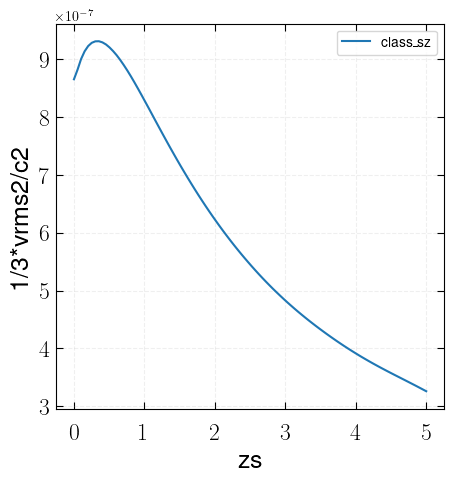

In [28]:
label_size = 17
title_size = 18
legend_size = 13
handle_length = 1.5
fig, (ax1) = plt.subplots(1,1,figsize=(5,5))
ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_xlabel(r"zs",size=title_size)
ax.set_ylabel(r"1/3*vrms2/c2",size=title_size) ## 1/3*vrms2 in units of c2

ax.plot(zs,vrms2,label='class_sz') ## 
ax.legend()

## Halo velocity dispersion

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})
import numpy as np
import os
from classy_sz import Class as Class_sz

**Cosmological parameters**

In [30]:
cosmo_params= {
    'omega_b': 0.02,
    'omega_cdm':  0.12,
    'H0': 80., 
    'tau_reio': 0.0561,
    'ln10^{10}A_s': 3.047,
    'n_s': 0.9665, 
    "cosmo_model": 0, # 1: use mnu-lcdm emulators; 0: use lcdm with fixed neutrino mass, currently vrms2 does not support emulators

}

**Precision parameters**

In [31]:
precision_params = {
## check k_min_for_pk_in_vrms2,... if needed
}

In [52]:
%%time

zmin = 0.
zmax = 5.

classy_sz = Class_sz()
classy_sz.set(cosmo_params)
classy_sz.set(precision_params)
classy_sz.set({
'output': 'vrms2',
'z_min' : zmin,
'z_max' : zmax,
# 'ndim_redshifts':100,
# 'skip_class_sz':0,
'skip_background_and_thermo': 0,
'ndim_masses':100,
'ndim_redshifts':100,
})
classy_sz.initialize_classy_szfast() 
# classy_sz.compute()

CPU times: user 3.1 s, sys: 2.22 s, total: 5.32 s
Wall time: 631 ms


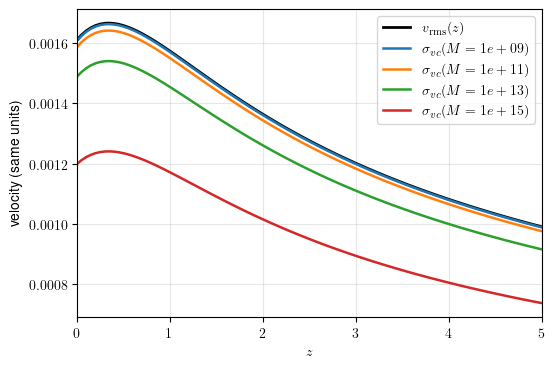

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson
from scipy.interpolate import RegularGridInterpolator
from mcfit import TophatVar

# ----------------------------------------------------------------------
# ASSUME you already have:
#   - classy_sz  (CLASS-SZ python object)
#   - cosmo_params  (dict)
# ----------------------------------------------------------------------
params_values_dict = cosmo_params
rparams = classy_sz.get_all_relevant_params(params_values_dict=params_values_dict)
h = rparams["h"]

# ----------------------------------------------------------------------
# 1. k-grid and z-grid
# ----------------------------------------------------------------------
z_ref = 1.0
_, ks = classy_sz.get_pkl_at_z(z_ref, params_values_dict=params_values_dict)  # (Nk,)
z_grid = classy_sz.z_grid()    # (Nz,)
Nz = z_grid.size

# build P(k,z) on that grid
pks_cols = []
for z_i in z_grid:
    pk_i, _ = classy_sz.get_pkl_at_z(z_i, params_values_dict=params_values_dict)
    pks_cols.append(pk_i.flatten())
P = np.stack(pks_cols, axis=1)     # (Nk, Nz)

# ----------------------------------------------------------------------
# 2. use mcfit to get σ0², σ_{-1}², σ1² for every z
#    σ_j²(R,z) = 1/(2π²) ∫ dk k^{2j+2} P(k,z) W²(kR)
#    mcfit.TophatVar does j=0, so do j=±1 by pre-multiplying P by k^{2j}
# ----------------------------------------------------------------------
TH = TophatVar(ks, lowring=True)

R = None
sig0_sq_cols  = []
sigm1_sq_cols = []
sig1_sq_cols  = []

for iz in range(Nz):
    Pk = P[:, iz]  # P(k, z_i)

    # j = 0
    R_i, sig0_sq_i = TH(Pk, extrap=True)

    # j = -1  -> multiply P by k^{-2}
    _, sigm1_sq_i = TH(Pk * ks**(-2), extrap=True)

    # j = +1  -> multiply P by k^{+2}
    _, sig1_sq_i = TH(Pk * ks**(+2), extrap=True)

    if R is None:
        R = R_i

    sig0_sq_cols.append(sig0_sq_i)
    sigm1_sq_cols.append(sigm1_sq_i)
    sig1_sq_cols.append(sig1_sq_i)

# (NR, Nz)
sigma_0  = np.sqrt(np.stack(sig0_sq_cols,  axis=1))
sigma_m1 = np.sqrt(np.stack(sigm1_sq_cols, axis=1))
sigma_1  = np.sqrt(np.stack(sig1_sq_cols,  axis=1))
NR = R.size

# ----------------------------------------------------------------------
# 3. map R -> M  (same formula you had)
#    M = 4π/3 ρ_cb,0 (R h)^3
# ----------------------------------------------------------------------
Rh = R * h
rho_cb_0 = rparams["Omega0_cb"] * rparams["Rho_crit_0"]
M_grid = (4.0 * np.pi / 3.0) * rho_cb_0 * Rh**3   # (NR,)

lnm_grid = np.log(M_grid)          # (NR,)
lnx_grid = np.log(1.0 + z_grid)    # (Nz,)

# ----------------------------------------------------------------------
# 4. interpolators (ln(1+z), lnM) -> σ_j
# ----------------------------------------------------------------------
sigma_m1_interp = RegularGridInterpolator(
    (lnx_grid, lnm_grid),
    sigma_m1.T,
    bounds_error=False,
    fill_value=None,
)
sigma_0_interp = RegularGridInterpolator(
    (lnx_grid, lnm_grid),
    sigma_0.T,
    bounds_error=False,
    fill_value=None,
)
sigma_1_interp = RegularGridInterpolator(
    (lnx_grid, lnm_grid),
    sigma_1.T,
    bounds_error=False,
    fill_value=None,
)

def _sigmaj_Mz(M, z, interp):
    M = np.asarray(M, float)
    z = np.asarray(z, float)
    M, z = np.broadcast_arrays(M, z)
    pts = np.stack([np.log(1.0 + z).ravel(), np.log(M).ravel()], axis=-1)
    out = interp(pts)
    return out.reshape(M.shape)

def sigma_Mz(M, z):
    return _sigmaj_Mz(M, z, sigma_0_interp)

# ----------------------------------------------------------------------
# 5. σ_v(M,z) and σ_vc(M,z)
#
# **IMPORTANT FIX**:
#   physical:  σ_v^2 = (f a H)^2 σ_{-1}^2  ⇒  σ_v = (f a H) σ_{-1}
#   (your earlier run had (f a H)^2 σ_{-1}, which makes it rise with z)
# ----------------------------------------------------------------------
def sigma_v_Mz(M, z, classy_sz):
    sig_m1 = _sigmaj_Mz(M, z, sigma_m1_interp)     # σ_{-1}(M,z)

    z = np.atleast_1d(np.asarray(z, float))
    f = np.array([classy_sz.scale_independent_growth_factor_f(zi) for zi in z])
    a = 1.0 / (1.0 + z)
    try:
        H = classy_sz.Hubble(z)
    except TypeError:
        H = np.array([classy_sz.Hubble(zi) for zi in z])

    pref = (f * a * H)               # NOTE: **one** power, not squared
    pref = np.broadcast_to(pref, sig_m1.shape)

    return pref * sig_m1

def sigma_vc_Mz(M, z, classy_sz):
    sig_v  = sigma_v_Mz(M, z, classy_sz)
    sig_m1 = _sigmaj_Mz(M, z, sigma_m1_interp)
    sig_0  = _sigmaj_Mz(M, z, sigma_0_interp)
    sig_1  = _sigmaj_Mz(M, z, sigma_1_interp)

    corr = 1.0 - (sig_0**4) / (sig_1**2 * sig_m1**2)
    corr = np.where(corr < 0, 0.0, corr)

    return sig_v * np.sqrt(corr)

# ----------------------------------------------------------------------
# 6. unsmoothed v_rms^2(z)   (your image)
#     v_rms^2(z) = 1/(2π²) ∫ dk (f a H)² P_lin(k,z)
# ----------------------------------------------------------------------
# def vrms2_of_z(classy_sz, z, k=None):
#     z = np.atleast_1d(np.asarray(z, float))

#     if k is None:
#         k = np.geomspace(1e-5, 1e1, 1000)
#     k = np.asarray(k, float)

#     P = np.array([classy_sz.pk_lin(k, zi) for zi in z])

#     f = np.array([classy_sz.scale_independent_growth_factor_f(zi) for zi in z])
#     a = 1.0 / (1.0 + z)
#     try:
#         H = classy_sz.Hubble(z)
#     except TypeError:
#         H = np.array([classy_sz.Hubble(zi) for zi in z])

#     pref = (f * a * H) ** 2
#     Ik = simpson(P, x=k, axis=1)

#     vrms2 = pref * Ik / (2.0 * np.pi**2)
#     return vrms2[0] if vrms2.size == 1 else vrms2

def vrms2_of_z(classy_sz, z, k=None):
    """
    v_rms^2(z) = 1/(2π^2) ∫ d ln k  (f a H)^2  P_lin(k,z)  k
    """
    import numpy as np
    from scipy.integrate import simpson

    z = np.atleast_1d(np.asarray(z, float))

    if k is None:
        k = np.geomspace(1e-5, 1e1, 1000)
    k = np.asarray(k, float)
    lnk = np.log(k)

    # P(k,z): (Nz, Nk)
    P = np.array([classy_sz.pk_lin(k, zi) for zi in z])

    # growth stuff
    f = np.array([classy_sz.scale_independent_growth_factor_f(zi) for zi in z])
    a = 1.0 / (1.0 + z)
    try:
        H = classy_sz.Hubble(z)
    except TypeError:
        H = np.array([classy_sz.Hubble(zi) for zi in z])

    pref = (f * a * H) ** 2          # (Nz,)

    # integrand = P * k  (because dk = k dlnk)
    Ik = simpson(P * k[None, :], x=lnk, axis=1)

    vrms2 = pref * Ik / (2.0 * np.pi**2)

    return vrms2[0] if vrms2.size == 1 else vrms2


# ----------------------------------------------------------------------
# 7. plot
# ----------------------------------------------------------------------
z_plot = np.linspace(0, 5, 100)
vrms2 = vrms2_of_z(classy_sz, z_plot)
vrms  = np.sqrt(vrms2)

Ms = [1e9,1e11, 1e13, 1e15]   # in the SAME units as M_grid above
sigma_vc_curves = {M: sigma_vc_Mz(M, z_plot, classy_sz) for M in Ms}

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(z_plot, vrms, label=r"$v_{\rm rms}(z)$", lw=2, color="k")
for M, col in zip(Ms, ["C0","C1", "C2", "C3"]):
    ax.plot(z_plot, sigma_vc_curves[M], lw=1.8, color=col,
            label=rf"$\sigma_{{vc}}(M={M:.0e})$")

ax.set_xlabel(r"$z$")
ax.set_ylabel(r"velocity (same units)")
ax.set_xlim(0, 5)
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()


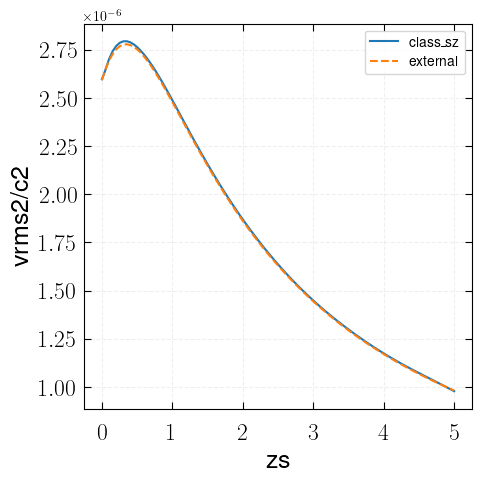

In [54]:
nzs = 100

zs = np.linspace(zmin,zmax,nzs)
vrms2 = vrms2_of_z(classy_sz, zs)
vrms2c = classy_sz.get_vrms2_at_z(zs)


label_size = 17
title_size = 18
legend_size = 13
handle_length = 1.5
fig, (ax1) = plt.subplots(1,1,figsize=(5,5))
ax = ax1
ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=5)
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')
plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
plt.setp(ax.get_xticklabels(), fontsize=label_size)
ax.grid( visible=True, which="both", alpha=0.2, linestyle='--')
ax.set_xlabel(r"zs",size=title_size)
ax.set_ylabel(r"vrms2/c2",size=title_size) ## 1/3*vrms2 in units of c2

ax.plot(zs,3.*vrms2c,label='class_sz') ## 
ax.plot(zs,vrms2,label='external',ls='--') ## 
ax.legend()